In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from nsepy import get_history

In [13]:
def obtain_data(ticker,start,end):
# Enter the start and end dates using the method date(yyyy,m,dd)    
    stock=get_history(symbol=ticker,start=start,end=end)
    df=stock.copy()
    df=df.reset_index()
    df=df.drop(['Series','Prev Close','Last','Turnover','%Deliverble','Trades'],axis=1)
    df=df.rename({'Open':'open_price','Close':'close_price','High':'high','Low':'low','Volume':'volume'},axis='columns')
    df.index=df.Date
    return df

In [15]:
"""This cell defineds the plot_candles function"""

def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['open_price']
    close_price = pricing['close_price']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]},figsize=(7,7))
    else:
        fig, ax1 = plt.subplots(1, 1)
    if title:
        ax1.set_title(title)
    fig.tight_layout()
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x , low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(True)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    ax1.set_yticklabels([])
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    #plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    if volume_bars:
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        #ax2.set_title(volume_title)
        ax2.xaxis.grid(True)
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])
    return fig

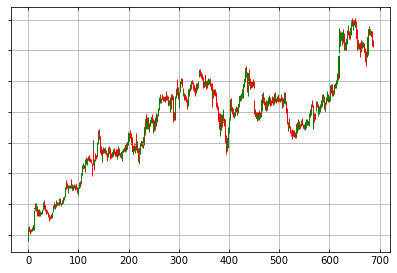

In [17]:
plot_candles(obtain_data("DMART",start=date(2016,1,1),end=date(2020,1,1)));